# Combining Sampling Methods with Attractor Dynamics in Spiking Models of Head-Direction Systems
## by Vojko Pjanovic, Jacob Zavatone-Veth, Paul Masset, Sander Keemink & Michele Nardin. 

Code written by Vojko Pjanovic and Michele Nardin.

This notebook includes the code for Fig. 3 and Supp. Fig. 3

In [ ]:
TODO: clean up

In [ ]:
# create signal
import numpy as np # for npU usage, simply replace cupy with numpy; everything works accordingly.
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.stats import johnsonsu
from scipy import stats

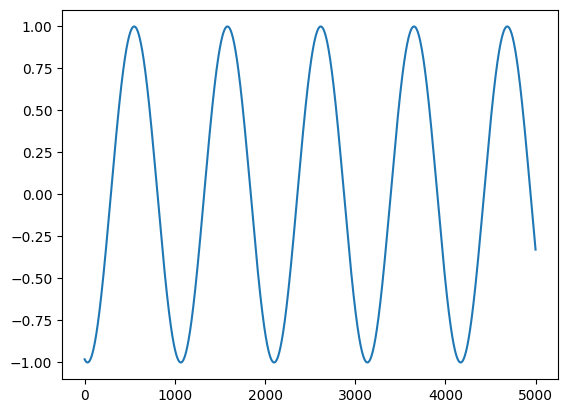

In [ ]:

np.random.seed(4)

# parameters
dt = 0.001  # time step
nt = 50000
length = nt - 1

K = 1

# K sinusoidal signals with random frequencies and amplitudes
zo_np = np.arange(1,K+1)/K * np.array([np.cos(np.linspace(b,10 + b,nt)*b) for b in np.random.rand(K)*np.pi]).T
zo = zo_np#.get()
plt.plot(zo[::10])
plt.show()

# generate poisson firing from Nr retinal neurons with exponential kernel
Nr = 100
beta = np.random.randn(int(Nr/2), K) #1111 random filters which translate signal size K to Nr firing rates
beta = np.clip(beta, -5, 5)
beta = np.concatenate((beta, -beta), axis=0) # Nr x K
A = beta
kernel = np.exp(zo_np @ beta.T) # firing rates
s = np.random.poisson(kernel) # KxN poisson samples P(s|z)

In [ ]:
np.max(beta)

2.654799403494359

In [ ]:
np.max(s)

30

(array([4.191113e+06, 6.642320e+05, 9.906100e+04, 2.627500e+04,
        1.173300e+04, 5.237000e+03, 1.852000e+03, 4.200000e+02,
        6.900000e+01, 8.000000e+00]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <BarContainer object of 10 artists>)

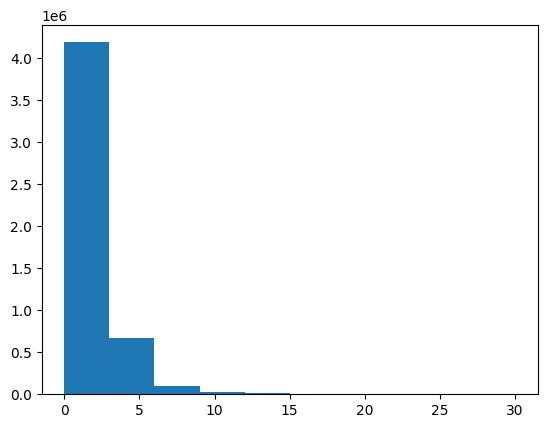

In [ ]:
plt.hist(s.flatten(), bins=10)

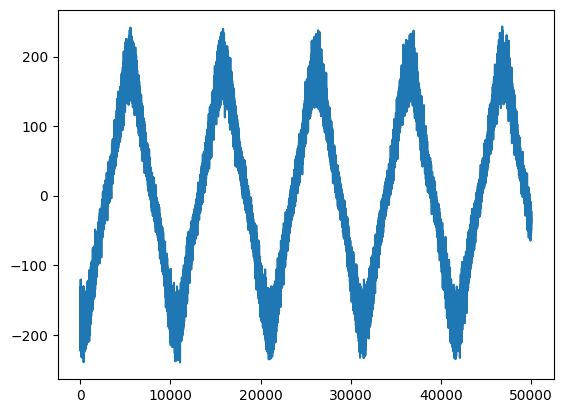

In [ ]:
plt.plot(s@beta)

In [ ]:
z = np.linspace(-1.3,1.3,1000)

In [ ]:
import math
from scipy.special import gammaln

In [ ]:
lks = []
for t in range(nt):
    ps = []
    for neur in range(100):
        ps.append(np.exp(s[t,neur]*A[neur]*z - np.exp(A[neur]*z) - gammaln(s[t,neur]+1)))
    lks.append(np.prod(ps, axis=0))

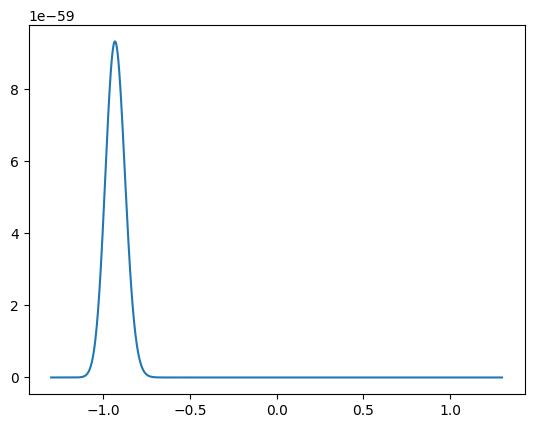

In [ ]:
plt.plot(z,lks[6])

In [ ]:
# Network parameters
Nn = 50 # Number of neurons

# decoding matrix: bunch of normalized and re-size random vectors
np.random.seed(42) # for reproducibility
D=np.random.randn(K,Nn) 
D = D / np.sqrt(np.diag(D.T@D))/10 # normalize vectors

# voltage decay constant
lam=1

# thresholds
T = np.diag(D.T@D)/2
V = np.zeros([Nn,nt+1])
sigma = np.zeros([Nn,nt+1])
r = np.zeros([Nn,nt+1])

# Set initial conditions
r[:,0] = np.array(np.linalg.pinv(D)@zo[0]) # set initial condition through pseudo-inverse
V[:,0] = 0.95*T # fairly close to firing thr
### network connections ###
# - fast
O_f = - D.T @ D
# - slow
O_s = lam * D.T @ D
# - nonlinear part (not biological plausible atm)
epsilon=1
A=beta
def O_nl(r,s): # will need to be adapted to multiplicative thingys
    return  epsilon * D.T @ A.T @(s - np.exp(A@D@r))
# simple forward Euler (check dt for OU)
for t in range(nt):
    V[:,t+1] = V[:,t] + dt*(-lam*V[:,t] + O_f@sigma[:,t] + O_s @ r[:,t] + O_nl(r[:,t],s[t])) + np.sqrt(epsilon*2*dt)*D.T@np.random.randn(K)
    
    # check if there are neurons whose voltage is above threshold
    above = np.where(V[:,t+1] > T)[0]
    
    # introduce a control to let only one neuron fire
    if len(above):
        sigma[np.argmax(V[:,t+1]),t+1] = 1/dt
    
    # update rate
    r[:,t+1] = r[:,t] + dt*(sigma[:,t+1] - lam*r[:,t])

In [ ]:
t

49999

In [ ]:
mscn_x_hat = D @ r[:, :t]

running_window = 1000
m1 = mean = ndimage.gaussian_filter1d( mscn_x_hat.T,running_window,axis=0)
m2 = ndimage.gaussian_filter1d((mscn_x_hat.T) ** 2, running_window, axis=0)
m3 = ndimage.gaussian_filter1d((mscn_x_hat.T) ** 3, running_window, axis=0)
m4 = ndimage.gaussian_filter1d((mscn_x_hat.T) ** 4, running_window, axis=0)

var = m2 - m1**2

std = sigma = var**0.5

skewness = (m3 - 3*m1*m2 + 2*m1**3) / (sigma**3)

kurtosis = (m4 - 4*m1*m3 + 6*m1**2*m2 - 3*m1**4) / (sigma**4)

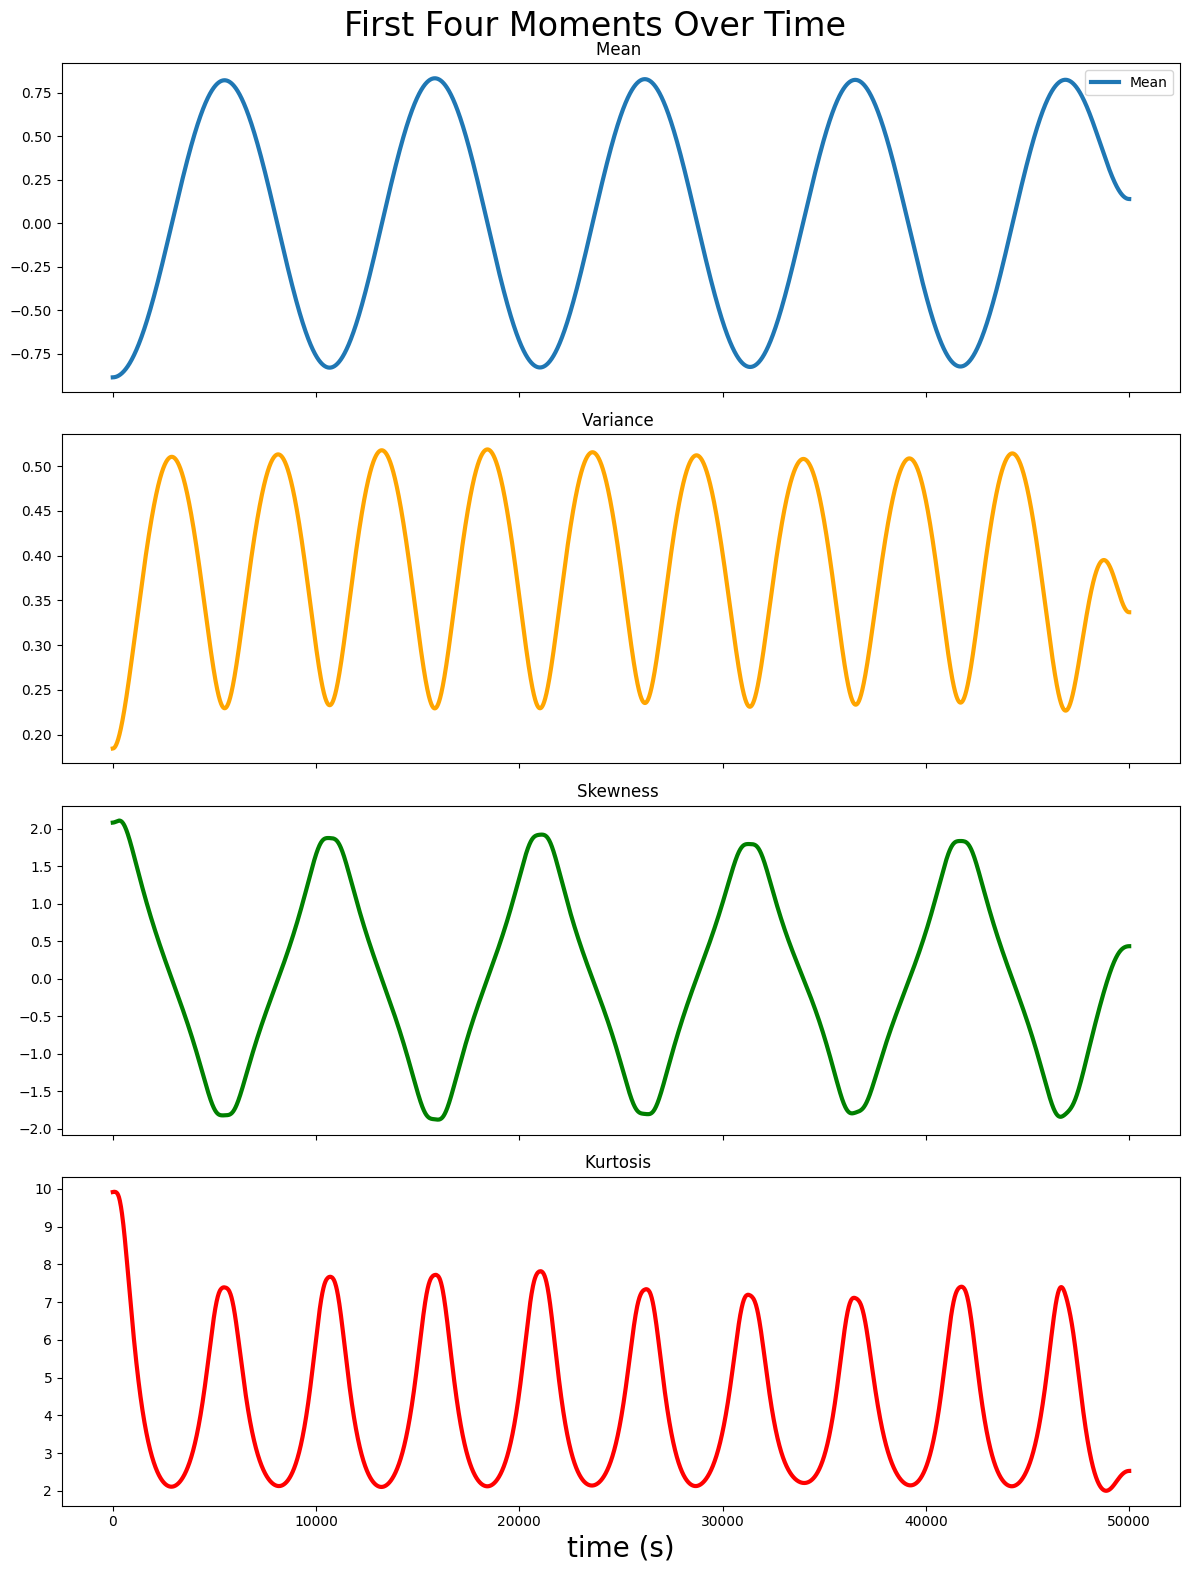

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

timesteps = range(t)
# Mean

# axs[0].plot(timesteps, zo[:-1], '--', label = 'True signal', linewidth = 3)
axs[0].plot(timesteps, mean, label='Mean', linewidth = 3)
axs[0].set_title('Mean ')
axs[0].legend(loc = 'upper right')
# axs[0].set_ylabel('Mean')

# Variance
axs[1].plot(timesteps, std, label='Variance', color='orange', linewidth = 3)
# axs[1].plot(timesteps, test_var)
axs[1].set_title('Variance ')
# axs[1].set_ylabel('Variance')

# Skewness
axs[2].plot(timesteps, skewness, label='Skewness', color='green', linewidth = 3)
# axs[2].plot(timesteps, test_skew, 'r')
axs[2].set_title('Skewness ')
# axs[2].set_ylabel('Skewness')

# Kurtosis
axs[3].plot(timesteps, kurtosis, label='Kurtosis', color='red', linewidth = 3)
# axs[3].plot(timesteps,test_kurt)
axs[3].set_title('Kurtosis ')
# axs[3].set_ylabel('Kurtosis')
axs[3].set_xlabel('time (s)', fontsize = 20)

# Set shared x-axis properties
# for ax in axs:
#     ax.set_xlim(0, 10000)
#     ax.set_xticks([0, 2000, 4000, 6000, 8000, 10000])
#     ax.set_xticklabels([0, 2, 4, 6, 8, 10], fontsize = 20)

fig.suptitle('First Four Moments Over Time', fontsize=24)

plt.tight_layout()
# plt.savefig('moments_over_time.svg')

plt.show()

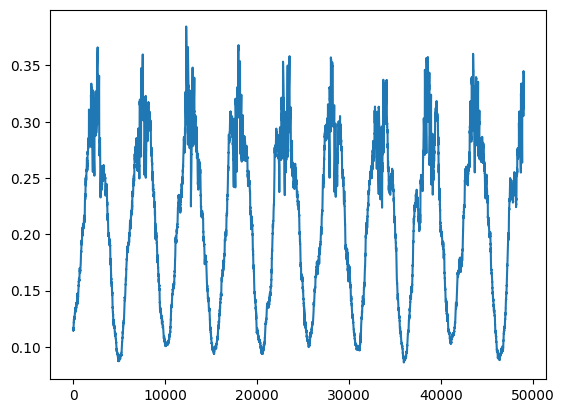

In [ ]:
# compute interquartile range for each running window
iqs = []
for i in range(nt - running_window):
    q75, q25 = np.percentile(mscn_x_hat.T[i:i+running_window], [75 ,25], axis=0)
    iqs.append(q75 - q25)
plt.plot(iqs)

In [ ]:
# compute variance, skewness, and kurtosis for each running window
mean = []
var = []
skewness = []
kurtosis = []

for i in range(nt - running_window):
    mean.append(np.mean(mscn_x_hat.T[i:i+running_window], axis=0))
    var.append(np.var(mscn_x_hat.T[i:i+running_window], axis=0))
    skewness.append(stats.skew(mscn_x_hat.T[i:i+running_window]))
    kurtosis.append(stats.kurtosis(mscn_x_hat.T[i:i+running_window]))

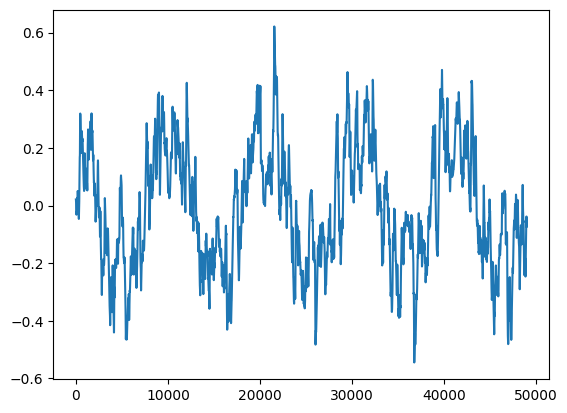

In [ ]:

# plt.plot(ndimage.gaussian_filter1d(np.array(var)[:,0],10))
plt.plot(ndimage.gaussian_filter1d(np.array(skewness)[:,0],10))
# plt.plot(ndimage.gaussian_filter1d(np.array(kurtosis)[:,0],10))

/tmp/ipykernel_940884/2340256221.py:3: RuntimeWarning: invalid value encountered in log
  return 1/k * np.nansum(np.log(x/x[-1]))


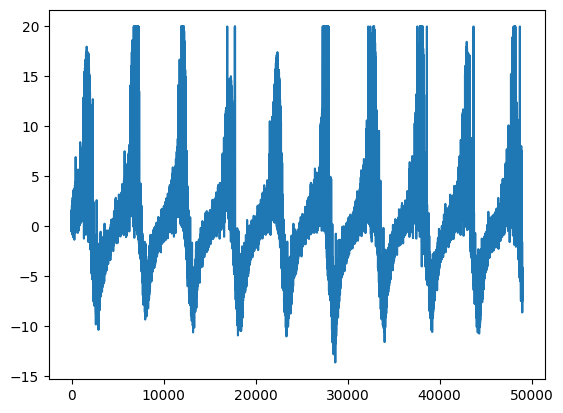

In [ ]:
# compute hill coefficient
def hill_estimator(x, k):
    return 1/k * np.nansum(np.log(x/x[-1]))
hills = []
for i in range(nt-running_window):
    x = np.sort(mscn_x_hat.T[i:i+running_window])
    k = 100
    hills.append(hill_estimator(x, k))
hills = np.clip(hills, -20, 20)
plt.plot(hills)

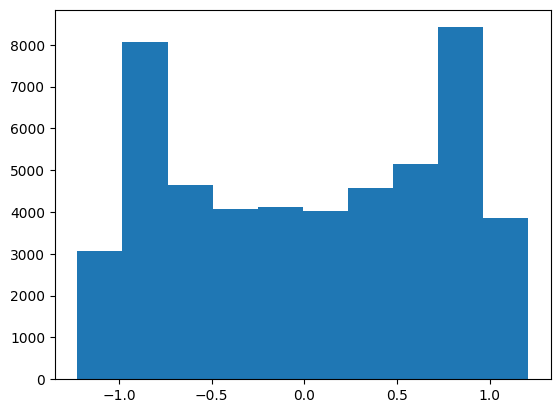

In [ ]:
c = plt.hist(mscn_x_hat.T, bins=10)

In [ ]:
bins = c[1]

/tmp/ipykernel_940884/3999540137.py:6: RuntimeWarning: divide by zero encountered in log
  entropies.append(-np.nansum(p*np.log(p)))
/tmp/ipykernel_940884/3999540137.py:6: RuntimeWarning: invalid value encountered in multiply
  entropies.append(-np.nansum(p*np.log(p)))


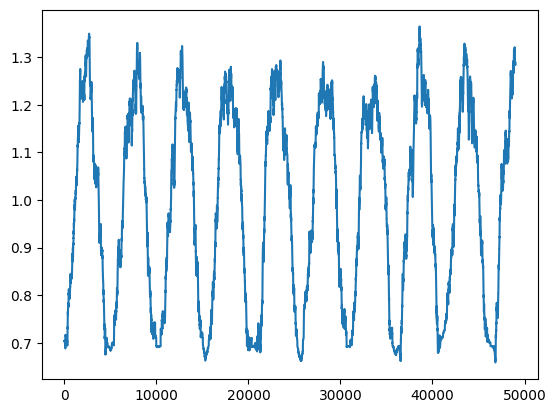

In [ ]:
# compute entropy of each histogram
entropies = []
for i in range(nt-running_window):
    h = np.histogram(mscn_x_hat.T[i:i+running_window], bins =bins)[0]
    p = h/h.sum()
    entropies.append(-np.nansum(p*np.log(p)))
plt.plot(entropies)

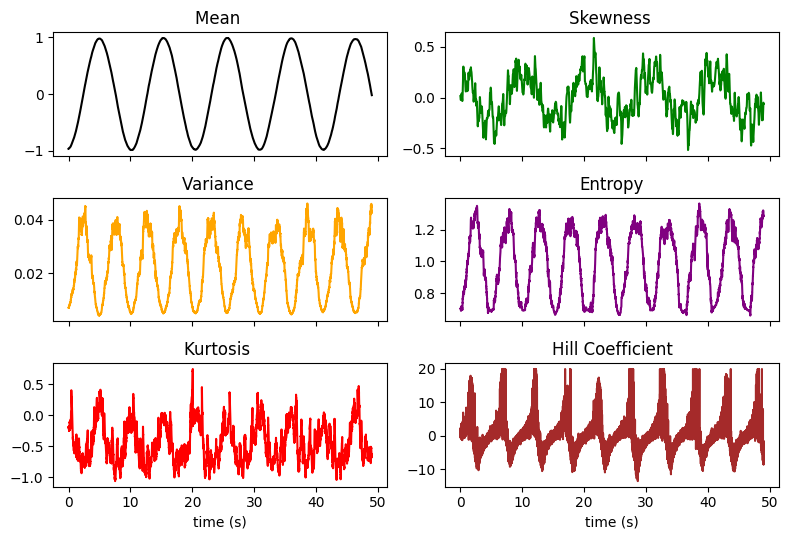

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(8, 5.5), sharex=True)

timesteps = range(nt - running_window)
# Mean

axs[0,0].plot(timesteps, mean,color='k')
axs[0,0].set_title('Mean ')

# Variance
axs[1,0].plot(timesteps, var, label='Variance', color='orange')
axs[1,0].set_title('Variance ')

# Skewness
axs[0,1].plot(timesteps, ndimage.gaussian_filter1d(np.array(skewness)[:,0],20), label='Skewness', color='green')
axs[0,1].set_title('Skewness ')

# Kurtosis
axs[2,0].plot(timesteps, kurtosis, label='Kurtosis', color='red')
axs[2,0].set_title('Kurtosis ')

# entropy
axs[1,1].plot(entropies,color='purple')
axs[1,1].set_title('Entropy')

# interquantile range
# axs[1,1].plot(iqs)
# axs[1,1].set_title('Interquantile Range')

# hill coefficient
axs[2,1].plot(hills,color='brown')
axs[2,1].set_title('Hill Coefficient')



for a in axs[2]:
    # for a in ax:
        a.set_xticks(np.arange(0, 50001, 10000))
        a.set_xticklabels(np.arange(0, 51, 10))
        a.set_xlabel('time (s)')

# fig.suptitle('Statistics Over Time', fontsize=24)

plt.tight_layout()
plt.savefig('moments_over_time.svg')

plt.show()

In [ ]:
def norm(x):
    return x / np.sum(x)

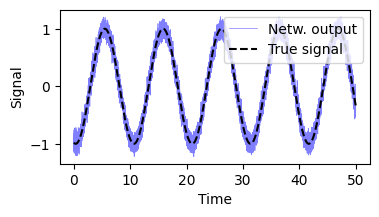

In [ ]:
plt.figure(figsize=(4, 2))
plt.plot(mscn_x_hat.T, label='Netw. output', color='b',alpha=0.5,lw=0.5)
plt.plot(zo, label='True signal', color='k',ls='--')
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(np.arange(0, 50001, 10000), np.arange(0, 51, 10))
# plt.tight_layout()
plt.savefig('network_output_vs real.svg')

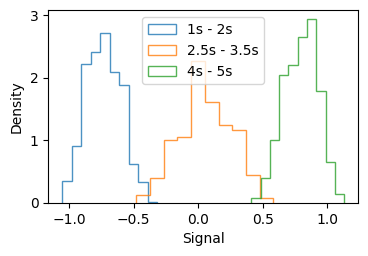

In [ ]:
plt.figure(figsize=(4, 2.5))
plt.hist(mscn_x_hat.T[1000:2000], bins=10, density=True, alpha=0.8,histtype='step', label = '1s - 2s')
plt.hist(mscn_x_hat.T[2500:3500], bins=10, density=True, alpha=0.8,histtype='step', label = '2.5s - 3.5s')
plt.hist(mscn_x_hat.T[4000:5000], bins=10, density=True, alpha=0.8,histtype='step', label = '4s - 5s')
plt.legend(loc=9)
plt.xlabel('Signal')
plt.ylabel('Density')
plt.savefig('histograms_posterior.svg')
plt.show()